# Evaluation Metrics for Classification

## Evaluation metrics: session overview
Metric - function that compares the predictions with the actual values and outputs a single number that tells how good the predictions are

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

In [7]:
df = pd.read_csv('../03-classification/churn_projection.csv')

df.columns = df.columns.str.lower().str.replace(' ', '_')

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ', '_')

df.totalcharges = pd.to_numeric(df.totalcharges, errors='coerce')
df.totalcharges = df.totalcharges.fillna(0)

df.churn = (df.churn == 'yes').astype(int)

In [8]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_train = df_train.churn.values
y_val = df_val.churn.values
y_test = df_test.churn.values

del df_train['churn']
del df_val['churn']
del df_test['churn']

In [9]:
numerical = ['tenure', 'monthlycharges', 'totalcharges']

categorical = [
    'gender',
    'seniorcitizen',
    'partner',
    'dependents',
    'phoneservice',
    'multiplelines',
    'internetservice',
    'onlinesecurity',
    'onlinebackup',
    'deviceprotection',
    'techsupport',
    'streamingtv',
    'streamingmovies',
    'contract',
    'paperlessbilling',
    'paymentmethod',
]

In [10]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

model = LogisticRegression()
model.fit(X_train, y_train)

/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression()

In [11]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_pred = model.predict_proba(X_val)[:, 1]
churn_decision = (y_pred >= 0.5)
(y_val == churn_decision).mean()

0.8034066713981547

## Accuracy and Dummy Model
- Evaluate the model on different thresholds
- Check the accuracy of dummy baselines

In [12]:
from sklearn.metrics import accuracy_score

In [13]:
accuracy_score(y_val, y_pred >= 0.5)

0.8034066713981547

In [14]:
thresholds = np.linspace(0, 1, 21)

scores = []

for t in thresholds:
    score = accuracy_score(y_val, y_pred >= t)
    print('%.2f %.3f' % (t, score))
    scores.append(score)

0.00 0.274
0.05 0.510
0.10 0.591
0.15 0.666
0.20 0.710
0.25 0.739
0.30 0.760
0.35 0.773
0.40 0.785
0.45 0.793
0.50 0.803
0.55 0.801
0.60 0.795
0.65 0.786
0.70 0.765
0.75 0.744
0.80 0.735
0.85 0.726
0.90 0.726
0.95 0.726
1.00 0.726


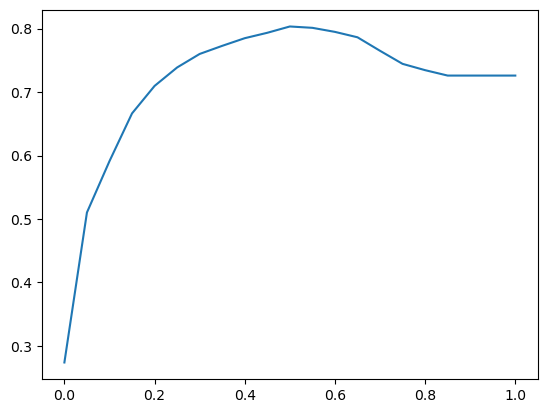

In [15]:
plt.plot(thresholds, scores)


In [16]:
from collections import Counter

In [17]:
Counter(y_pred >= 1.0)

Counter({False: 1409})

In [18]:
# Accuracy score of dummy model
1 - y_val.mean()

0.7260468417317246

## Confusion Table
- Different types of errors and correct decisions
- Arranging them in a table

In [27]:
# Positive: churn
actual_positive = (y_val == 1)
# Negative: not churn
actual_negative = (y_val == 0)

In [32]:
t = 0.5
predict_positive = (y_pred >= t)
predict_negative = (y_pred < t)

In [38]:
# predicted value = actual value = positive (1) -> True
true_positive = (predict_positive & actual_positive).sum()
# predicted value = actual value = negative (0) -> True
true_negative = (predict_negative & actual_negative).sum()

In [39]:
# predict value = positive (1), actual value = negative (0) -> False
false_positive = (predict_positive & actual_negative).sum()
# predict value = negative (0), actual value = positive (1) -> False
false_negative = (predict_negative & actual_positive).sum()

In [40]:
true_positive, true_negative, false_positive, false_negative

(210, 922, 101, 176)

In [42]:
confusion_matrix = np.array([[true_negative,false_positive],[false_negative,true_positive]])
confusion_matrix

array([[922, 101],
       [176, 210]])

In [46]:
(confusion_matrix / confusion_matrix.sum()).round(2)

array([[0.65, 0.07],
       [0.12, 0.15]])

## Precision and Recall

In [47]:
# Accuracy
(true_positive + true_negative)/(true_positive + true_negative + false_positive + false_negative)

0.8034066713981547

### Precision

In [48]:
# Precision: how many positive predictions are correct? Predicted value为底
# TP / (TP + FP)
precision = true_positive / (true_positive + false_positive)
precision

0.6752411575562701

### Recall

In [52]:
# Recall: how many positive targets are identified？Actual value为底
# TP / (TP + FN)
recall = true_positive / (true_positive + false_negative)
recall

0.5440414507772021

## ROC Curves

### TPR and FRP

In [55]:
# False Positive Rate = FP / (TN + FP), 以actual value =  Negative为底，数值越小越好
false_positive_rate = false_positive / (true_negative + false_positive)
false_positive_rate

0.09872922776148582

In [57]:
# True Positive Rate = TP / (FN + TP), 以actual value = Positive为底，数值越大越好
true_positive_rate = true_positive / (false_negative + true_positive)
true_positive_rate

0.5440414507772021

In [58]:
scores = []

thresholds = np.linspace(0, 1, 101)

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)
    
    predict_positive = (y_pred >= t)
    predict_negative = (y_pred < t)

    tp = (predict_positive & actual_positive).sum()
    tn = (predict_negative & actual_negative).sum()

    fp = (predict_positive & actual_negative).sum()
    fn = (predict_negative & actual_positive).sum()
    
    scores.append((t, tp, fp, fn, tn))

In [59]:
columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
df_scores = pd.DataFrame(scores, columns = columns)

In [71]:
df_scores['tpr']= df_scores.tp/(df_scores.tp+df_scores.fn)
df_scores['fpr']= df_scores.fp/(df_scores.fp+df_scores.tn)

In [72]:
df_scores

,threshold,tp,fp,fn,tn,tpr,fpr
0,0.00,386,1023,0,0,1.000000,1.000000
1,0.01,385,913,1,110,0.997409,0.892473
2,0.02,384,830,2,193,0.994819,0.811339
3,0.03,383,766,3,257,0.992228,0.748778
4,0.04,381,715,5,308,0.987047,0.698925
...,...,...,...,...,...,...,...
96,0.96,0,0,386,1023,0.000000,0.000000
97,0.97,0,0,386,1023,0.000000,0.000000
98,0.98,0,0,386,1023,0.000000,0.000000
99,0.99,0,0,386,1023,0.000000,0.000000


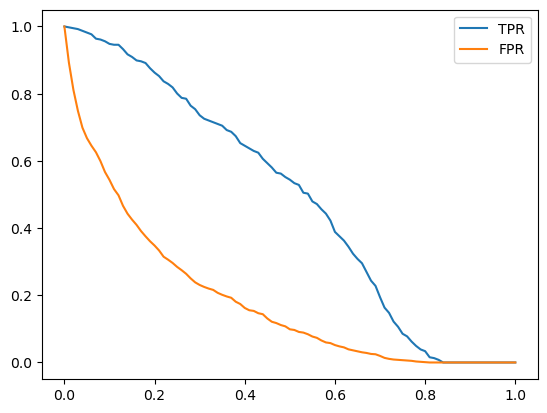

In [100]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR')
plt.legend()

## Random Model

In [76]:
np.random.seed(1)
y_rand = np.random.uniform(0, 1, size=len(y_val))

In [77]:
def tpr_fpr_dataframe(y_val, y_pred):
    scores = []
    
    thresholds = np.linspace(0, 1, 101)
    
    for t in thresholds:
        actual_positive = (y_val == 1)
        actual_negative = (y_val == 0)
        
        predict_positive = (y_pred >= t)
        predict_negative = (y_pred < t)
    
        tp = (predict_positive & actual_positive).sum()
        tn = (predict_negative & actual_negative).sum()
    
        fp = (predict_positive & actual_negative).sum()
        fn = (predict_negative & actual_positive).sum()
        
        scores.append((t, tp, fp, fn, tn))

    columns = ['threshold', 'tp', 'fp', 'fn', 'tn']
    df_scores = pd.DataFrame(scores, columns = columns)

    df_scores['tpr']= df_scores.tp/(df_scores.tp+df_scores.fn)
    df_scores['fpr']= df_scores.fp/(df_scores.fp+df_scores.tn)

    return df_scores
    

In [82]:
df_rand = tpr_fpr_dataframe(y_val, y_rand)

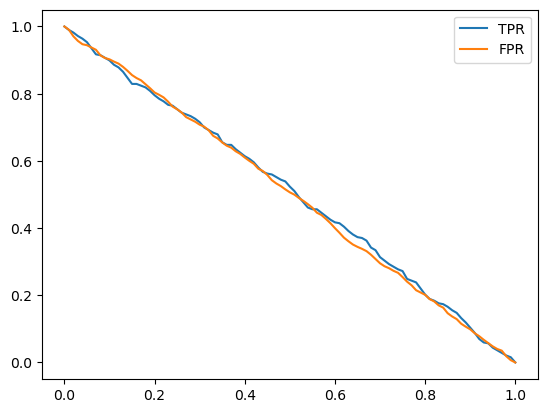

In [83]:
plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR')
plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR')
plt.legend()

## Ideal Model

In [84]:
num_neg = (y_val == 0).sum()
num_pos = (y_val == 1).sum()
num_pos, num_neg

(386, 1023)

In [85]:
y_ideal = np.repeat([0,1], [num_neg, num_pos])
y_ideal

array([0, 0, 0, ..., 1, 1, 1])

In [90]:
y_ideal_pred = np.linspace(0,1,len(y_val))

In [91]:
1 - y_val.mean()

0.7260468417317246

In [92]:
((y_ideal_pred >= 0.726) == y_ideal).mean()  

1.0

In [93]:
df_ideal = tpr_fpr_dataframe(y_ideal, y_ideal_pred)

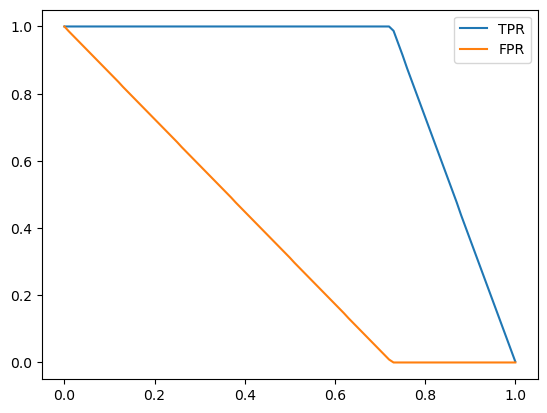

In [94]:
plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR')
plt.legend()
#当threshold值越小，越多的y判定为Positive，True Positive and False Positive数量也越来越大
#当threshold数值足够小的时候, 所有的True Positive会被全部捕捉到，而False Negative=0, 则TPR无限接近于1
#反之
#当threshold值越大，越多的y判定为Negative, True Negative and False Negative数量也会越老越大
#当threshold数值足够大的时候，所有的True Negative会被捕捉到，而False Positive=0, 则FPR无限接近于0

## Putting Everything Together

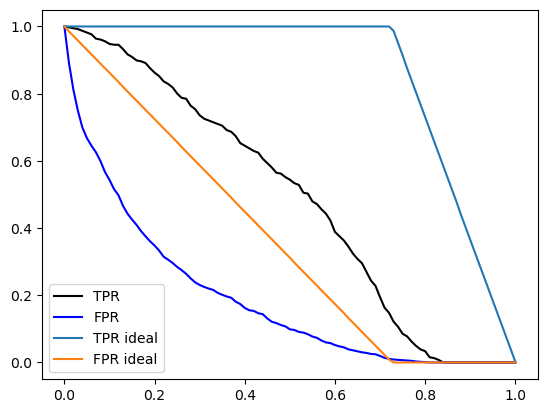

In [95]:
plt.plot(df_scores.threshold, df_scores['tpr'], label='TPR', color='black')
plt.plot(df_scores.threshold, df_scores['fpr'], label='FPR', color='blue')

plt.plot(df_ideal.threshold, df_ideal['tpr'], label='TPR ideal')
plt.plot(df_ideal.threshold, df_ideal['fpr'], label='FPR ideal')

# plt.plot(df_rand.threshold, df_rand['tpr'], label='TPR random', color='grey')
# plt.plot(df_rand.threshold, df_rand['fpr'], label='FPR random', color='grey')

plt.legend()

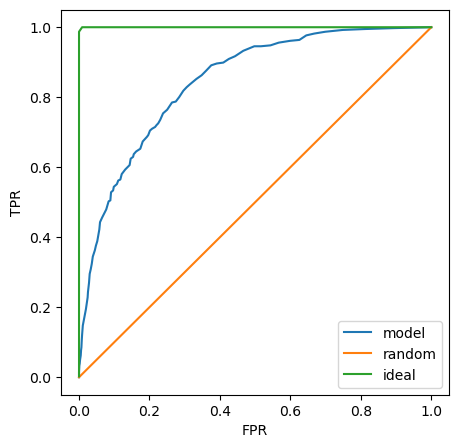

In [115]:
plt.figure(figsize=(5,5))

plt.plot(df_scores['fpr'], df_scores['tpr'], label='model')
plt.plot([0,1], [0,1], label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()
# Ultimate goal: model的curve越靠近ideal的curve越好, 越远离random的curve越好
# 当threshold足够准确, False Positive and False Negative = 0
# True Positive Rate = 1, False Positive Rate = 0


# 当threshold = 0, 所有的y判定为Positive (1)
# True Positive and False Positive达到最大值, True Negative and False Negative = 0
# True Positive Rate = 1, False Positive Rate = 1

# 当threshold = 1, 所有的y判定为Negative (0)
# True Negative and False Negative达到最大值, True Positive and False Positive = 0
# True Positive Rate = 0, False Positive Rate = 0




In [118]:
from sklearn.metrics import roc_curve

In [119]:
fpr, tpr, threshold = roc_curve(y_val, y_pred)

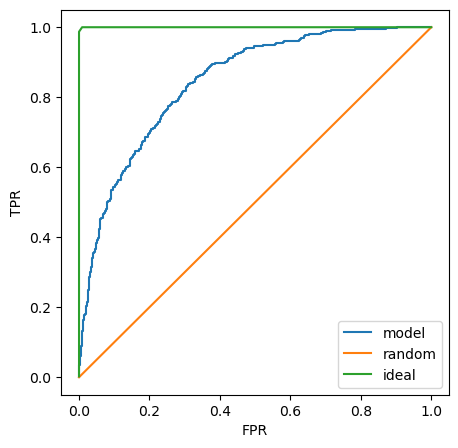

In [121]:
plt.figure(figsize=(5,5))

plt.plot(fpr, tpr, label='model')
plt.plot([0,1], [0,1], label='random')
plt.plot(df_ideal.fpr, df_ideal.tpr, label='ideal')

plt.xlabel('FPR')
plt.ylabel('TPR')

plt.legend()

## ROC AUC
- Area under the ROC curve - useful metric
- Interpretation of AUC

In [122]:
from sklearn.metrics import auc

In [123]:
auc(fpr, tpr)

0.8438226490207101

In [125]:
auc(df_scores['fpr'], df_scores['tpr'])

0.8438125193097614

In [126]:
auc(df_ideal['fpr'], df_ideal['tpr'])

0.9999430203759136

In [127]:
# roc_curve 计算false positive rate and true positive rate
fpr, tpr, threshold = roc_curve(y_val, y_pred)
# auc 计算roc curve下的面积
auc(fpr, tpr)

0.8438226490207101

In [128]:
from sklearn.metrics import roc_auc_score

In [129]:
roc_auc_score(y_val, y_pred)

0.8438226490207101

In [130]:
# 把1和0对应位置的prediction挑出来
neg = y_pred[y_val == 0]
pos = y_pred[y_val == 1]

In [131]:
# 随机从neg和pos里面各挑选一个prediction，比较这两个predictions的大小
# 理论上，actual value = 1对应的prediction probability 更大
# actual value = 0 对应的prediction probability更小
# 所以在对比这两个probabilities时，pos应该永远大于neg
import random
n = 100000
success = 0 

for i in range(n):
    pos_ind = random.randint(0, len(pos) - 1)
    neg_ind = random.randint(0, len(neg) - 1)

    if pos[pos_ind] > neg[neg_ind]:
        success = success + 1

success / n

0.84457

In [ ]:
n = 50000

np.random.seed(1)
pos_ind = np.random.randint(0, len(pos), size=n)
neg_ind = np.random.randint(0, len(neg), size=n)

(pos[pos_ind] > neg[neg_ind]).mean()

## K-Fold Cross Validation
- Evaluating the same model on different subsets of data
- Getting the average prediction and the spread within predictions

In [153]:
def train(df, y_train, C = 1.0):
    dicts =  df[categorical+numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)
    # C is regularization, max_iter to limit iteration times
    model = LogisticRegression(C=C, max_iter=1000)
    model.fit(X_train, y_train)

    return dv, model

In [154]:
dv, model = train(df_train, y_train, C=10)

In [136]:
def predict(df, dv, model):
    dicts =  df[categorical+numerical].to_dict(orient='records')

    X = dv.transform(dicts)

    y_pred = model.predict_proba(X)[:,1]

    return y_pred

In [137]:
y_pred = predict(df_val, dv, model)

array([0.00900623, 0.20398953, 0.21159498, ..., 0.13634037, 0.79963872,
       0.83731644])

In [138]:
from sklearn.model_selection import KFold

In [141]:
kfold = KFold(n_splits = 10, shuffle=True, random_state=1)

In [144]:
train_idx, val_idx = next(kfold.split(df_full_train))

In [145]:
len(train_idx), len(val_idx)

(5070, 564)

In [146]:
df_train = df_full_train.iloc[train_idx]
df_val = df_full_train.iloc[val_idx]

In [151]:
!pip install tqdm

In [159]:
!pip install --upgrade tqdm


  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.5
    Uninstalling tqdm-4.66.5:
      Successfully uninstalled tqdm-4.66.5


In [167]:
from sklearn.model_selection import KFold
from tqdm.auto import tqdm

n_splits = 5

for C in tqdm([0.001, 0.01, 0.1, 0.5, 1, 5, 10]):
    kfold = KFold(n_splits = n_splits, shuffle=True, random_state=1)
    
    scores = []
    
    for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]
    
        y_train = df_train.churn.values
        y_val = df_val.churn.values
    
        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)
    
        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)
    print(C, np.mean(scores), np.std(scores))





                                                                                                                              | 0/7 [00:00<?, ?it/s]




Exception ignored in: <function tqdm.__del__ at 0x12c6313a0>
Traceback (most recent call last):
  File "/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'





04it/s]




74it/s]




84it/s]




93it/s]




5it [00:01,  3.78it/s]




██████████▊                                                                                                           | 1/7 [00:01<00:07,  1.33s/it]

0.001 0.8247638005146394 0.008951431037211766




0:00, ?it/s]

0:00,  4.27it/s]

0:00,  4.61it/s]

0:00,  4.70it/s]

0:00,  4.78it/s]

5it [00:01,  4.66it/s]




████████████████████████████▋                                                                                         | 2/7 [00:02<00:05,  1.18s/it]

0.01 0.8399303561494819 0.00882786538251834




0:00, ?it/s]

0:00,  4.37it/s]

0:00,  4.57it/s]

0:00,  4.61it/s]

0:00,  4.66it/s]

5it [00:01,  4.50it/s]




██████████████████████████████████████████████▌                                                                       | 3/7 [00:03<00:04,  1.16s/it]

0.1 0.8403123467492073 0.008005149627624298




0:00, ?it/s]

0:00,  2.88it/s]

0:00,  3.58it/s]

0:00,  4.09it/s]

0:01,  4.10it/s]

5it [00:01,  3.94it/s]




████████████████████████████████████████████████████████████████▍                                                     | 4/7 [00:04<00:03,  1.20s/it]

0.5 0.8398351267622095 0.006733948278421026




0:00, ?it/s]

0:00,  4.92it/s]

Exception ignored in: <function tqdm.__del__ at 0x12c6313a0>
Traceback (most recent call last):
  File "/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'
Exception ignored in: <function tqdm.__del__ at 0x12c6313a0>
Traceback (most recent call last):
  File "/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/tqdm/std.py", line 1148, in __del__
    self.close()
  File "/Users/gabrielle/opt/anaconda3/lib/python3.9/site-packages/tqdm/notebook.py", line 279, in close
    self.disp(bar_style='danger', check_delay=False)
AttributeError: 'tqdm_notebook' object has no attribute 'disp'


0:01,  2.03it/s]

0:01,  2.61it/s]

5it [00:01,  2.91it/s]




███████████████████████████

1 0.8403078369168192 0.008518108684808196


5it [00:01,  4.50it/s]




████████████████████████████████████████████████████████████████████████████████████████████████████▏                 | 6/7 [00:07<00:01,  1.30s/it]

5 0.8407454175756139 0.007485169891598703


5it [00:01,  4.12it/s]




100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 7/7 [00:08<00:00,  1.27s/it]

10 0.8412000944885438 0.007788458665960019


In [168]:
dv, model = train(df_full_train, df_full_train.churn.values, C=1)
y_pred = predict(df_test, dv, model)

auc = roc_auc_score(y_test, y_pred)
auc

0.8572386167896259

In [169]:
scores

[0.8423515004984655,
 0.845792361938816,
 0.8326028496889424,
 0.8325545980686833,
 0.8526991622478115]